In [1]:
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import pandas as pd

%matplotlib inline

seed = 20
np.random.seed(seed)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
d = 5
n = 100
test_n = 10

In [3]:
# data generation 

w = np.random.uniform(-10, 10, d )
X = np.random.rand(n, d)
_X = np.sin(X).ravel()
_y = np.sum(np.multiply(X, w), axis=1)
y = _y
# Add noise to targets
y[::5] += 3 * (0.5 - np.random.rand(y[::5].shape[0]))

# test data
X_new = np.random.rand(test_n, d)
_X_new = np.sin(X_new).ravel()
_y_new = np.sum(np.multiply(X_new, w), axis=1)
y_new = _y_new

print(X.shape)
print(_y.shape)

(100, 5)
(100,)


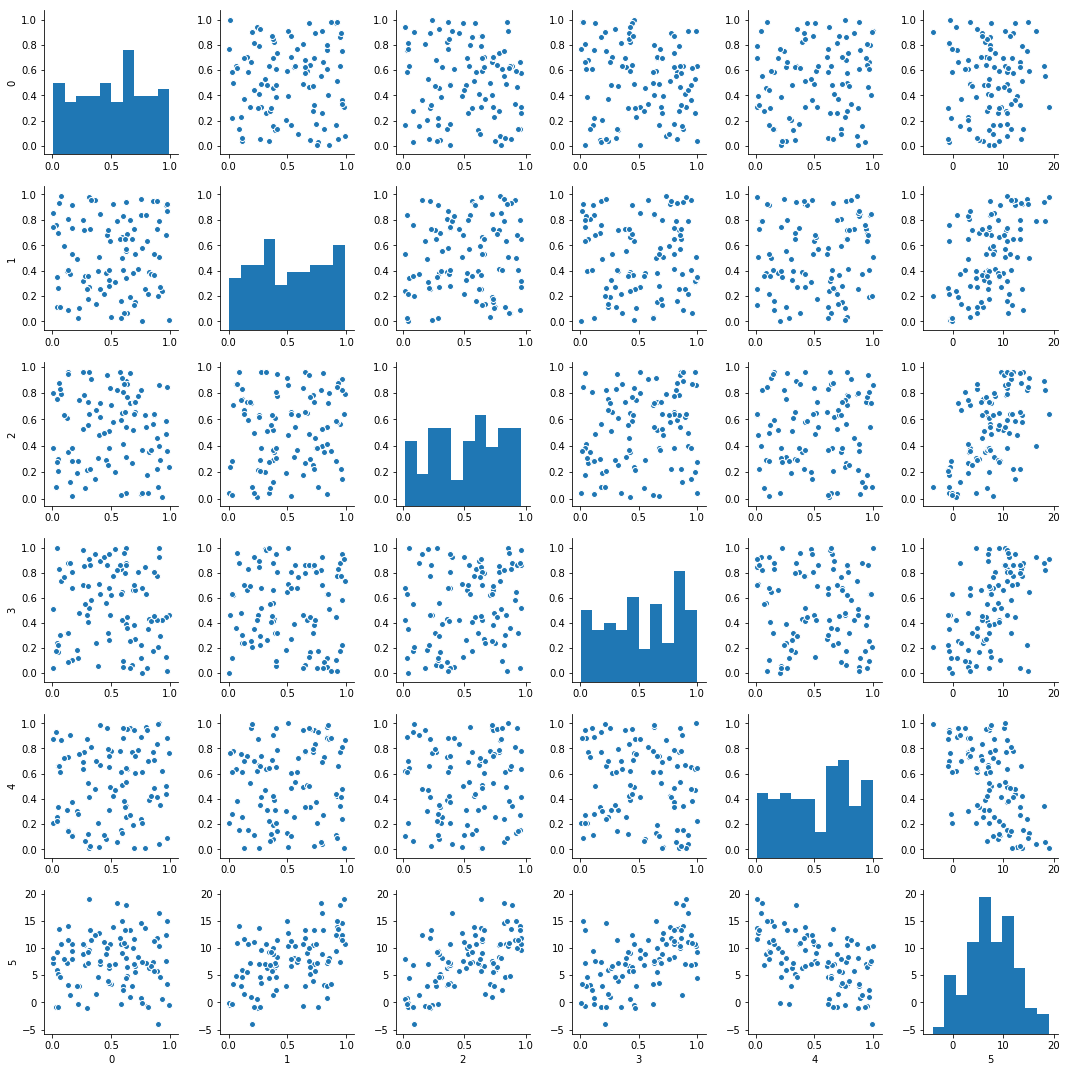

In [4]:
sns.pairplot(pd.DataFrame(np.hstack([X, np.reshape(_y, (n, 1))])));

In [5]:
# bayesian rbf kernel
with pm.Model() as model:
    # hyper-prior for ls
    ls = pm.Beta("ls", alpha=1e-2, beta=1e-4)
    cov_func = pm.gp.cov.ExpQuad(X.shape[1], ls=ls)

    # Specify the GP.
    gp = pm.gp.Marginal(cov_func=cov_func)

    # Place a GP prior over the function f.
    sigma = pm.HalfNormal("sigma", 1)
    y_ = gp.marginal_likelihood("y", X=X, y=y, noise=sigma)
    # inference
    map1 = pm.find_MAP()

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '27385' (I am process '42660')
logp = -327.64, ||grad|| = 3.2714: 100%|██████████| 15/15 [00:00<00:00, 146.86it/s]


In [6]:
map1

{'ls': array(1.),
 'ls_logodds__': array(602.99507664),
 'sigma': array(0.18086281),
 'sigma_log__': array(-1.71001651)}

In [7]:
with model:
    pred = gp.predict(X_new, point=map1)

In [8]:
# Fit sklearn regression models
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)

y_rbf = svr_rbf.fit(X, y).predict(X_new)
y_poly = svr_poly.fit(X, y).predict(X_new)

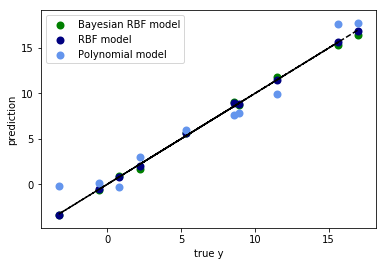

In [9]:
# plot prediction vs true y
lw = 2
plt.plot(y_new, y_new, ls="--", color = "black")
plt.scatter(y_new, pred[0], color='green', lw=lw, label='Bayesian RBF model')
plt.scatter(y_new, y_rbf, color='navy', lw=lw, label='RBF model')
plt.scatter(y_new, y_poly, color='cornflowerblue', lw=lw, label='Polynomial model')
plt.xlabel('true y')
plt.ylabel('prediction')
plt.legend();